In [3]:
import numpy as np
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
from PIL import Image


## Pupil Function

In [4]:
from scipy import ndimage, misc
def create_angle_split(image_size, h, w, ho, wo, angle):
    arr = np.zeros((image_size,image_size))
    half = image_size//2
    arr[half+ho-h:half+h+ho, half-w+wo:half+w+wo] = 1
    arr = ndimage.rotate(arr, angle, order=1, reshape=False)
    arr[arr>0]=1
    
    return arr

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

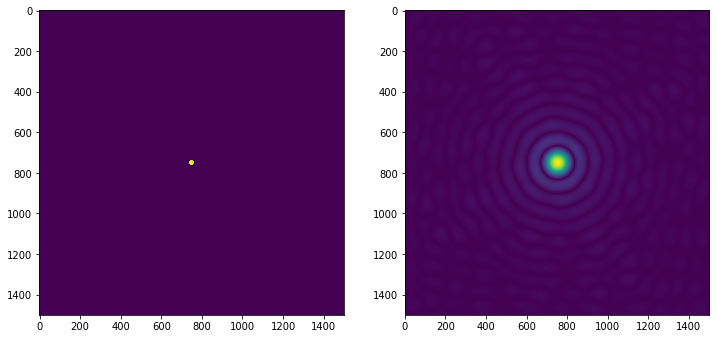

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 24))
aprtr = np.asarray(Image.open("aperture5.jpg")) / 255.0
ax1.imshow(aprtr)

afft = np.abs(np.fft.fft2(np.round(aprtr).astype(float)))
ax2.imshow(np.fft.fftshift(afft))

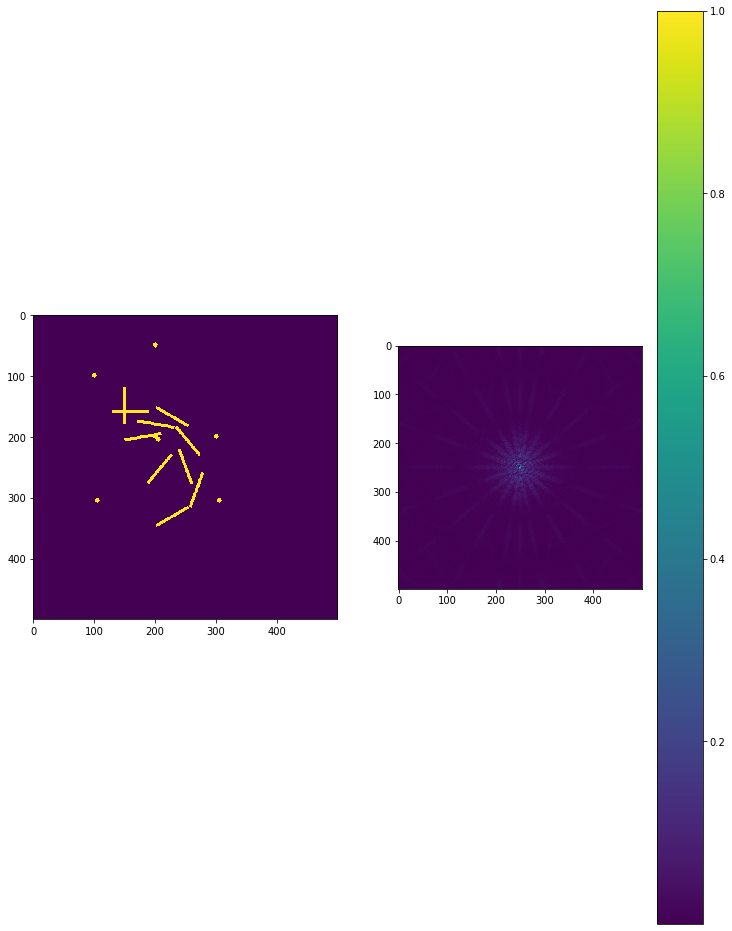

In [5]:
imsz = 500 
h = 30
w = 2
arr1 = create_angle_split(imsz, h, w, 0, 0, 20)
arr2 = create_angle_split(imsz, h, w, 30, 30, -20)
arr3 = create_angle_split(imsz, h, w, -30, 30, 40)
arr4 = create_angle_split(imsz, h, w, 30, -30, -40)
arr5 = create_angle_split(imsz, h, w, -60, 60, 60)
arr6 = create_angle_split(imsz, h, w, 60, 60, -60)
arr7 = create_angle_split(imsz, h, w, -60, 60, 80)
arr8 = create_angle_split(imsz, h, w, 60, -60, -80)
arr9 = create_angle_split(imsz, h, w, 90, -90, -90)
arr0 = create_angle_split(imsz, h, w, 100, 100, 180)
c = create_circular_mask(imsz, imsz, radius=4, center=(200, 50))
c += create_circular_mask(imsz, imsz, radius=4, center=(200, 200))
c += create_circular_mask(imsz, imsz, radius=4, center=(205, 205))
c += create_circular_mask(imsz, imsz, radius=4, center=(100, 100))
c += create_circular_mask(imsz, imsz, radius=4, center=(105, 305))
c += create_circular_mask(imsz, imsz, radius=4, center=(300, 200))
c += create_circular_mask(imsz, imsz, radius=4, center=(305, 305))

arr = arr1 + arr2 + arr3 + arr4 + arr5 + arr6 + arr7 + arr8 + arr9 + arr0 + c
arr[arr>0] = 1
arr_fft = np.abs(np.fft.fft2(arr.astype(float))) 
arr_fft = arr_fft / np.max(arr_fft)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 24))
ax1.imshow(arr)
im = ax2.imshow(np.fft.fftshift(arr_fft))
fig.colorbar(im)

In [80]:
np.random.uniform(0, 180, 1).item()

149.77979722304303

(-0.5, 999.5, 999.5, -0.5)

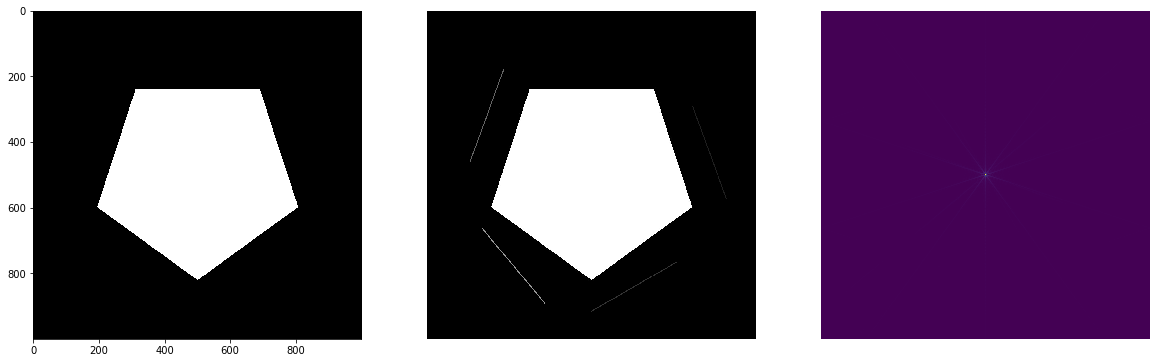

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 54))
rootdir = "/home/aatifjiwani/Documents/BerkeleySenior/CS184/lens-flare-milestone/images/"
image = np.asarray(Image.open("pentbig.jpg")) / 255.0
ax1.imshow(np.round(image), cmap="gray")

ims = 1000
h = 150
w = 1
# 20, -20, 40, -50, 90, -60
im2 = image + create_angle_split(ims, h, w, 60, 360, 20) * 6
im2 += create_angle_split(ims, h, w, -60, -360, -20) * 20
im2 += create_angle_split(ims, h, w, 60, -360, 40) * 30
# im2 += create_angle_split(ims, h, w, 50, 50, -50) * 10
im2 += create_angle_split(ims, h, w, 0, 360, 90) * 20
im2 += create_angle_split(ims, h, w, 60, 360, -60) * 10
im2 += image * 50


ax2.imshow(np.round(im2), cmap="gray")
ax2.axis('off')
# extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
# fig.savefig(rootdir + "pentf32.jpg", bbox_inches=extent.expanded(1.0, 0.5))

arr = np.abs(np.fft.fft2(np.round(im2).astype(float)))
ax3.imshow(np.fft.fftshift(arr) ** 0.7)
ax3.axis('off')


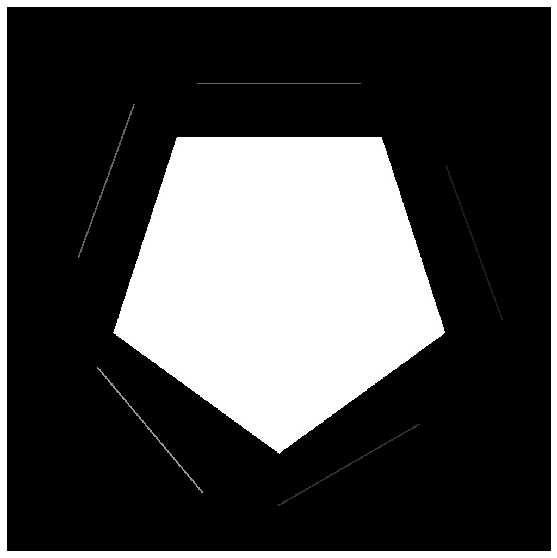

In [119]:
plt.figure(figsize=(10,10))
plt.imshow(np.round(im2), cmap="gray")
plt.axis('off')
plt.savefig(rootdir + "pentf1p4.jpg", bbox_inches='tight')

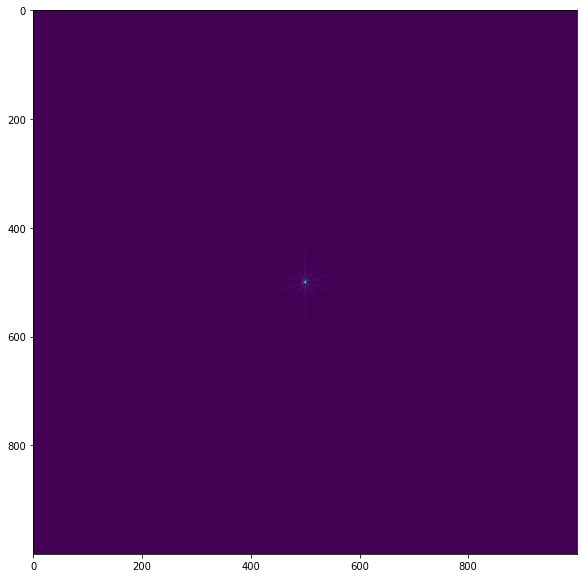

In [120]:
plt.figure(figsize=(10,10))
plt.imshow(np.fft.fftshift(arr) ** 0.8)
# plt.axis('off')
# plt.savefig(rootdir + "pentf32.jpg", bbox_inches='tight')

[3.41335364e-04 3.41335364e-04 1.21489281e-03 ... 5.53620956e+02
 5.55536447e+02 8.13918355e+02]


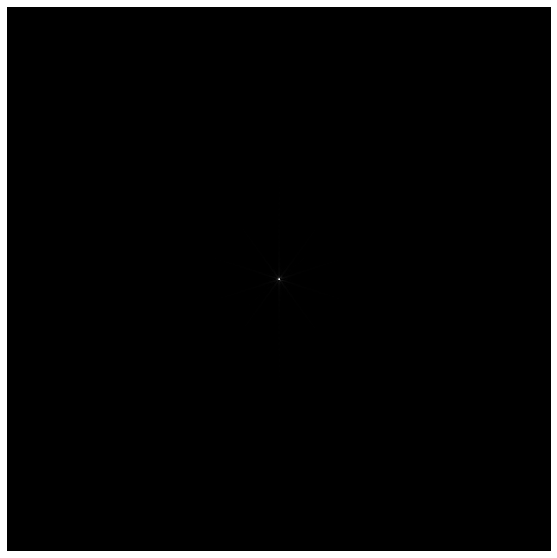

In [121]:
plt.figure(figsize=(10,10))
t = np.fft.fftshift(arr) ** 0.9 * 550e-9
tr = np.repeat(np.expand_dims(t, axis=2), 3, axis=2)

im2p = im2.astype("complex64") * create_df_phase(500, 550e-9, 500, 1)
arr2 = np.abs(np.fft.fft2(im2p)) ** 0.9
s = np.fft.fftshift(arr2) * 750e-9
sr = np.repeat(np.expand_dims(s, axis=2), 3, axis=2)

lambda550 = np.array([1, 1, 1]) * 255;
lambda0 = np.array([1, 1, 1]) * 255;

trgb = tr * lambda550 + sr * lambda0
print(np.unique(trgb))
plt.imshow((trgb * (255.0 / np.max(trgb))).astype(np.uint8))
plt.axis('off')
plt.savefig(rootdir + "pentf21p4_starburst.jpg", bbox_inches='tight')
# plt.colorbar()

[0. 1.]


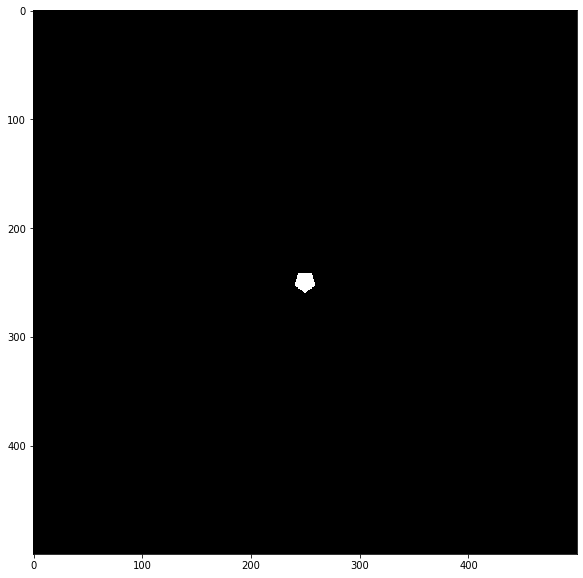

In [183]:
image = np.asarray(Image.open("pent3.jpg")) / 255.0
plt.figure(figsize=(10,10))
plt.imshow(np.round(image), cmap="gray")
np.max(image), np.min(image)
print(np.unique(np.round(image)))

(500, 500)


array([  0.,   4.,   5.,   6.,  10.,  11.,  14.,  15.,  16.,  17.,  18.,
        19.,  20.,  21.,  25.,  27.,  28.,  29.,  30.,  31.,  33.,  34.,
        35.,  37.,  39.,  40.,  41.,  43.,  45.,  46.,  47.,  48.,  50.,
        51.,  52.,  53.,  56.,  57.,  59.,  61.,  62.,  65.,  66.,  67.,
        71.,  77.,  81.,  86.,  87.,  91., 101., 107., 111., 117., 121.,
       131., 137., 147., 166., 167., 187.])

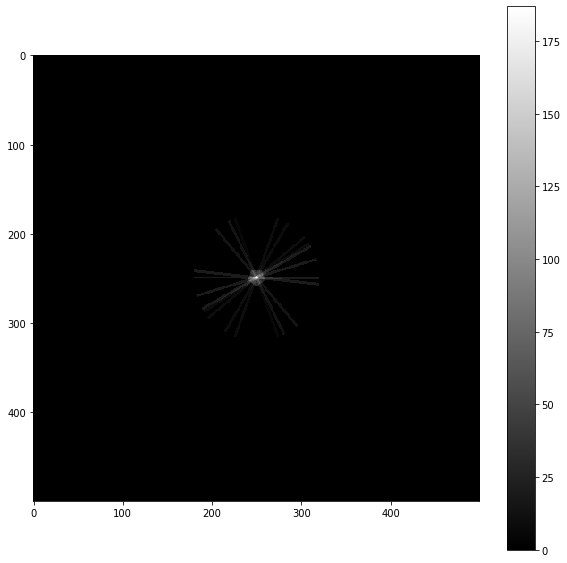

In [202]:
h = 70
w = 1
im2 = image + create_angle_split(500, h, w, 0, 0, 20) * 6
im2 = im2 + create_angle_split(500, h, w, 0, 0, -20) * 10
im2 = im2 + create_angle_split(500, h, w, 0, 0, 40) * 15
im2 = im2 + create_angle_split(500, h, w, 0, 0, -50) * 10
im2 = im2 + create_angle_split(500, h, w, 0, 0, 90) * 20
im2 = im2 + create_angle_split(500, h, w, 0, 0, -60) * 20
im2 = im2 + create_angle_split(500, h, w, 0, 0, -30) * 10
im2 = im2 + create_angle_split(500, h, w, 0, 0, 26) * 15
im2 = im2 + create_angle_split(500, h, w, 0, 0, -57) * 10
im2 = im2 + create_angle_split(500, h, w, 0, 0, 84) * 20
im2 = im2 + create_angle_split(500, h, w, 0, 0, -73) * 20
im2 += image * 30
im2 = np.round(im2)
im2 = im2


# im2[242:243, :] = 1
# im2[259:261, :] = 1
# im2[:, 241:242]=1
# im2[:, 258:259]=1
print(im2.shape)
# im2 = np.max(im2)"" - im2
# print(np.max(im2))
# im2 = im2 + create_angle_split(500, 30, w, 0, 0, 70)
# im2 = im2 + create_angle_split(500, 30, w, -30, -30, -20)
plt.figure(figsize=(10,10))
plt.imshow(im2, cmap="gray")
plt.colorbar()
np.max(im2), np.min(im2)
np.unique(im2)

In [205]:
i = Image.fromarray(((im2 / np.max(im2))*255).astype(np.uint8))
i.save('pentsmalllottalines.png')

72070.0


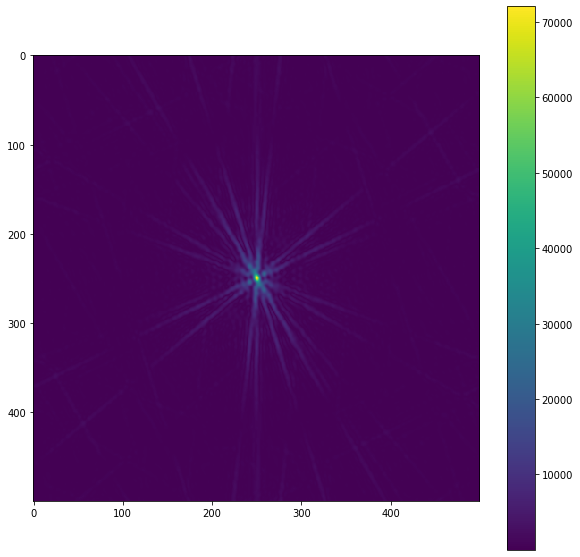

In [204]:
print(im2.sum())
plt.figure(figsize=(10,10))
arr = np.abs(np.fft.fft2(im2))
plt.imshow(np.fft.fftshift(arr))
plt.colorbar()

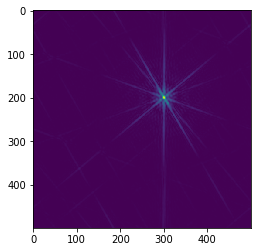

In [156]:
plt.imshow(np.fft.fftshift(arr))

In [167]:
def convertCoordinate(pixel_coord, length, y):
    if y:
        coord_center = -float(pixel_coord) + float(length) / 2.0
    else:
        coord_center = float(pixel_coord) - float(length) / 2.0

    if coord_center >= 0:
        return coord_center
    return length + coord_center

width = 500
x = convertCoordinate(0, width, False)
y = convertCoordinate(0, width, True)

k = np.arange(-width//2, width//2) * (1.0 / width)
ku, kv = np.meshgrid(k, k)
# print(k)
# print(ku,kv)

phase = np.exp(-1j * 2 * np.pi * (ku * x + kv * y))


print("Projected", abs((im2 * phase * create_phase_matrix(500, 50, -50)).sum()))

print("Actual", arr[250,250])
print("Test", np.fft.fftshift(arr)[0, 0])

total_int = 0
for yc in range(184, 316):
    for xc in range(180, 320):
        samp = float(np.round(im2)[yc, xc])
        
        u = ku[0, xc]
        v = kv[yc, 0]
        if (yc == 242 and xc == 241):
            print(u, v)
        
        exponent = u * x + v *y
#         complex_exp = np.exp(-1j * 2.0 * np.pi * (exponent))
        complex_exp = np.cos(2 * np.pi * exponent) - 1j * np.sin(2 * np.pi * exponent)
        if (yc == 242 and xc == 241):
            print("e", exponent)
            print("p", 2 * np.pi * exponent)
            print("c", np.cos(2 * np.pi * exponent))
            print("s", np.sin(2 * np.pi * exponent))
            
        other_exponent = (u * 50 + v * -50)
        o_complex_exp = np.cos(2 * np.pi * other_exponent) + 1j * np.sin(2 * np.pi * other_exponent)
        
        intensity = samp * complex_exp * o_complex_exp
        
#         if (samp == 1):
#             print(complex_exp, intensity)
        
        total_int += intensity
#         if (samp==1):
#             print(total_int)
        
print(total_int)
print(abs(total_int))

Projected 16.079827101800635
Actual 16.079827101806387
Test 16.079827101806387
-0.018000000000000002 -0.016
e -8.5
p -53.40707511102649
c -1.0
s 1.4708141202500005e-15
(16.079526825620935-0.0982684483253915j)
16.079827101800554


In [129]:
2e-14/5e-15

4.0

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
False True


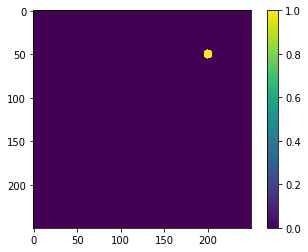

In [160]:
aperature_function = create_circular_mask(250, 250, radius=5, center=(200, 50))
print(aperature_function)
# aperature_function = np.zeros((250,250))
# aperature_function[100:150, 120:130] = 1

print(np.min(aperature_function), np.max(aperature_function))
plt.imshow(aperature_function.astype(np.uint8))
plt.colorbar()

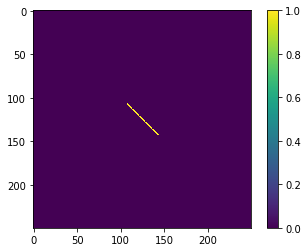

In [170]:
slit = create_angle_split(250, 250, 2, 200)
plt.imshow(slit.astype(np.uint8))
plt.colorbar()

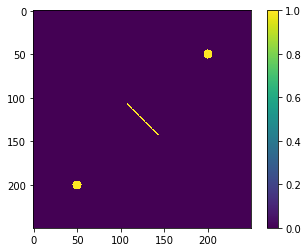

In [171]:
circle_slit = aperature_function + slit + create_circular_mask(250, 250, radius=5, center=(50, 200))
plt.imshow(circle_slit.astype(np.uint8))
plt.colorbar()

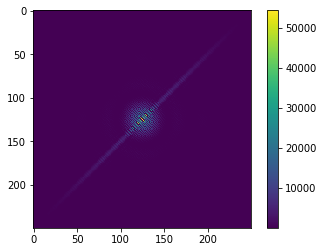

In [172]:
circle_fourier = np.abs(np.fft.fft2(circle_slit.astype(float))) ** 2
plt.imshow(np.fft.fftshift(circle_fourier))
plt.colorbar()

In [ ]:
np.exp(1j * 2 * np.pi * (u * x_off + v * y_off))

In [135]:
origin = (200, 100)
depth = 300

def create_phase_matrix(width, lr_shift, ud_shift):
    k = np.arange(-width//2, width//2) * (1.0 / width)
    kx, ky = np.meshgrid(k, k)

    return np.exp(1j * 2 * np.pi * (kx * lr_shift + ky * ud_shift)).astype('complex')

def create_df_phase(width, wavelength, R, z0):
    wavenumber = 2 * np.pi / wavelength
    wv550 = 2 * np.pi / 550.0e-9
    
    k = np.arange(-width//2, width//2) * (1.0 / width)
    kx, ky = np.meshgrid(k, k)
    
    r_xy = np.sqrt(kx * kx + ky * ky) / R
    
    W_m = np.random.normal(0, 5 / wv550, 1)
    
    return np.exp(1j * np.pi)
    
    
    

(1.0, 0.0)

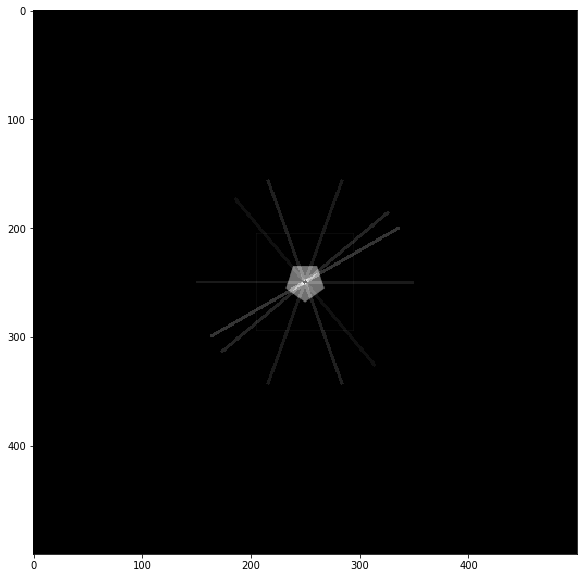

In [564]:
plt.figure(figsize=(10,10))
plt.imshow(np.round(im2), cmap="gray")
np.max(image), np.min(image)

<Figure size 720x720 with 0 Axes>

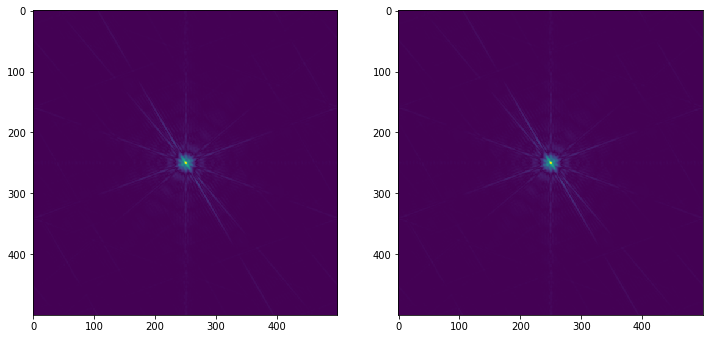

In [622]:
plt.figure(figsize=(10,10))
im2p = im2.astype("complex64")
arr = np.abs(np.fft.fft2(im2p))
arr = arr / np.max(arr)

im2p = im2.astype("complex64") * create_df_phase(500, 550e-9, 500, 1)
arr2 = np.abs(np.fft.fft2(im2p))
arr2 = arr2 / np.max(arr2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 24))

ax1.imshow(np.fft.fftshift(arr))
ax2.imshow(np.fft.fftshift(arr2))

In [465]:
np.random.normal(0, 1, 1)

array([-0.38961137])

class:  ndarray
shape:  (250, 250)
strides:  (4000, 16)
itemsize:  16
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x891cbe0
byteorder:  little
byteswap:  False
type: complex128


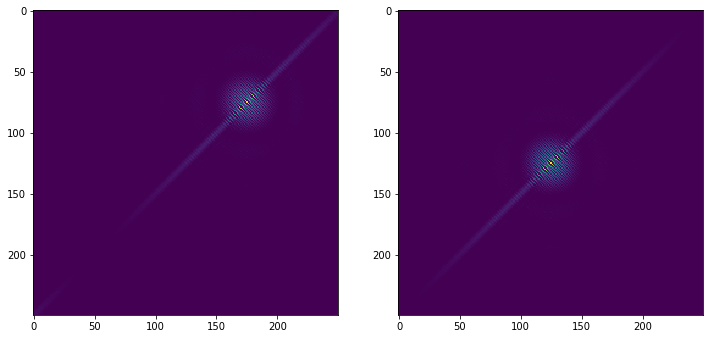

In [173]:
phase = create_phase_matrix(250,50,-50)
pupil_func = circle_slit.astype(np.complex64) * phase

np.info(pupil_func)


t = np.abs(np.fft.fft2(pupil_func)) ** 2
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 24))

ax1.imshow(np.fft.fftshift(t))
ax2.imshow(np.fft.fftshift(circle_fourier))

## Spectral Response Function

In [280]:
from scipy.stats import norm

In [281]:
wavelengths = np.arange(380, 745, 5)

In [282]:
mu_R = np.random.uniform(620, 640, 1)
mu_G = np.random.uniform(540, 560, 1)
mu_B = np.random.uniform(460, 480, 1)

sigma_R = np.random.uniform(50, 60, 1)
sigma_G = np.random.uniform(50, 60, 1)
sigma_B = np.random.uniform(50, 60, 1)

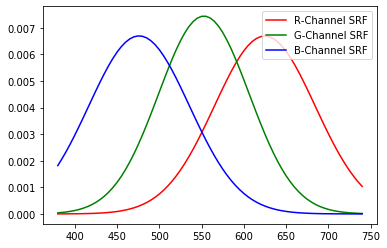

In [283]:
# Example SRF
plt.plot(wavelengths, norm.pdf(wavelengths, mu_R, sigma_R), color='r', label='R-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_G, sigma_G), color='g', label='G-Channel SRF')
plt.plot(wavelengths, norm.pdf(wavelengths, mu_B, sigma_B), color='b', label='B-Channel SRF')
plt.legend()

In [284]:
SRF_R = norm.pdf(wavelengths, mu_R, sigma_R)[None, :]
SRF_G = norm.pdf(wavelengths, mu_G, sigma_G)[None, :]
SRF_B = norm.pdf(wavelengths, mu_B, sigma_B)[None, :]

In [285]:
SRF = np.concatenate((SRF_R, SRF_G, SRF_B), axis=0)
SRF.shape

(3, 73)

## Combining

In [558]:
pupil_fourier = np.fft.fftshift(arrf)
psf = np.repeat(np.expand_dims(pupil_fourier, axis=0), 73, axis=0)
psf = psf.reshape(73, -1)

In [559]:
psf_rgb = (SRF @ psf)

In [560]:
psf_rgb = psf_rgb.reshape(3, 500, 500)

In [554]:
psf_rgb = psf_rgb / np.max(psf_rgb)

In [561]:
psf_rgb

array([[[15.73368858, 13.9918029 , 10.56732621, ...,  9.31940772,
         10.56732621, 13.9918029 ],
        [14.81417513, 15.5705332 , 12.3245759 , ..., 11.97367327,
          9.54603312, 11.44485589],
        [12.55169512, 16.10080984, 15.37113965, ..., 13.34637627,
          8.63126966,  8.61809118],
        ...,
        [10.11446096,  7.25389842,  8.92636322, ..., 16.31745763,
         17.96668461, 15.18799346],
        [12.55169512,  8.61809118,  8.63126966, ..., 11.11897914,
         15.37113965, 16.10080984],
        [14.81417513, 11.44485589,  9.54603312, ...,  8.17505629,
         12.3245759 , 15.5705332 ]],

       [[16.11183533, 14.3280848 , 10.82130353, ...,  9.54339231,
         10.82130353, 14.3280848 ],
        [15.1702221 , 15.94475864, 12.62078733, ..., 12.26145103,
          9.77546447, 11.71992394],
        [12.85336517, 16.48778006, 15.74057283, ..., 13.66714586,
          8.83871539,  8.82522017],
        ...,
        [10.35755402,  7.42824013,  9.14090129, ..., 1

In [556]:
psf_rgb.shape

(3, 500, 500)

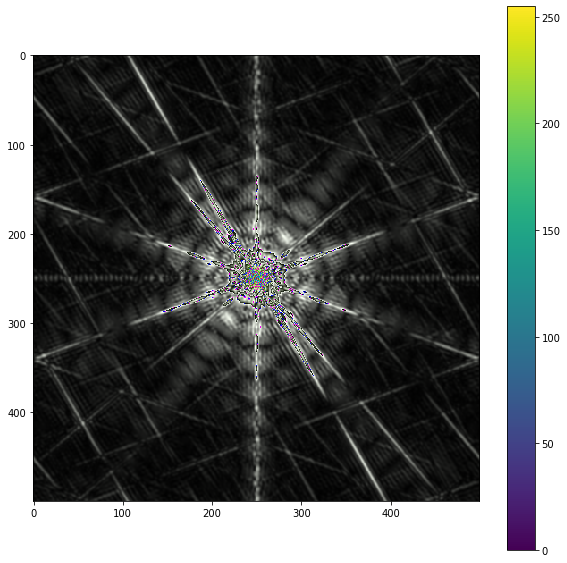

In [562]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(psf_rgb.astype(np.uint8), (1, 2, 0)))
plt.colorbar()

In [ ]:
[PathTracer] Input scene file: ../dae/sky/dragon.dae
[PathTracer] Rendering using 16 threads
found directional light with position (0.231147,0.744471,-1.01025) and spec (0,0,0)
found directional light with position (-0.456002,0.684922,0.508563) and spec (0,30,0)
[PathTracer] Collecting primitives... Done! (0.0148 sec)
[PathTracer] Building BVH from 105120 primitives... Done! (0.1816 sec)
have num lights 3
Analyzing Directional Light with world coords: (0.231147,0.744471,-1.01025)
position of coord in camera: (0.231147,0.723932,-4.26381)
position of coord on image plane in camera: (0.0542114,0.169785,-1)
camera image plane edges x,y: 0.274286, 0.274286